In [3]:
#import

In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
#import data

In [6]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 4500 files belonging to 3 classes.


HTML("""
<iframe width="560" height="315"frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
""")

In [17]:
all_class = data.class_names
all_class

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [18]:
for image_batch, labels_batch in data.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


In [19]:
#visualisation 

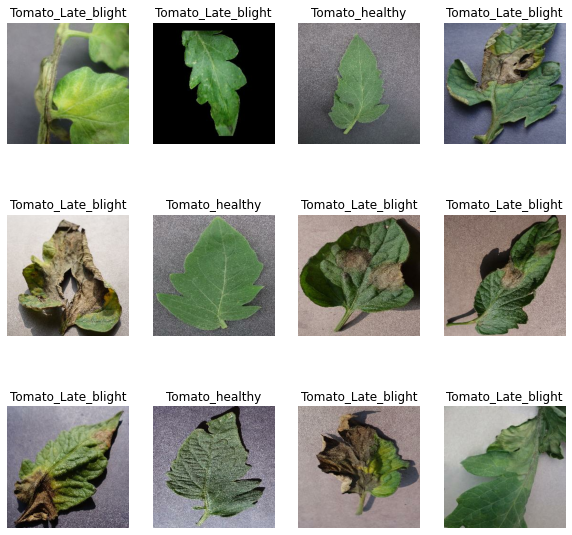

In [24]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [25]:
#data split

In [26]:
len(data)

141

In [27]:
train_size = 0.8
len(data)*train_size

112.80000000000001

In [28]:
test_ds = data.skip(112)
len(test_ds)

29

In [29]:
val_size=0.1
len(data)*val_size

14.100000000000001

In [30]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [31]:
test_ds = test_ds.skip(6)
len(test_ds)

23

In [32]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [33]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

In [34]:
len(train_ds)

112

In [35]:
len(val_ds)

14

In [36]:
len(test_ds)

15

In [38]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [39]:
#Model

In [40]:
#resize & normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [41]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [43]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [44]:
#Architecture
input_shape = (32,256,256,3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [47]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [49]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 207s 2s/step - loss: 1.0245 - accuracy: 0.4499 - val_loss: 0.9039 - val_accuracy: 0.5469
Epoch 2/50
112/112 [==============================] - 188s 2s/step - loss: 0.8249 - accuracy: 0.6097 - val_loss: 0.7455 - val_accuracy: 0.6942
Epoch 3/50
112/112 [==============================] - 175s 2s/step - loss: 0.6523 - accuracy: 0.7240 - val_loss: 0.7474 - val_accuracy: 0.6763
Epoch 4/50
112/112 [==============================] - 174s 2s/step - loss: 0.5756 - accuracy: 0.7618 - val_loss: 0.5020 - val_accuracy: 0.7723
Epoch 5/50
112/112 [==============================] - 195s 2s/step - loss: 0.5038 - accuracy: 0.7965 - val_loss: 0.4031 - val_accuracy: 0.7835
Epoch 6/50
112/112 [==============================] - 179s 2s/step - loss: 0.4616 - accuracy: 0.8043 - val_loss: 0.3786 - val_accuracy: 0.8036
Epoch 7/50
112/112 [==============================] - 194s 2s/step - loss: 0.4237 - accuracy: 0.8138 - val_loss: 0.3538 - val_accuracy: 0.8393

In [50]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 8s 508ms/step - loss: 0.0838 - accuracy: 0.9667


In [51]:
scores

[0.08380312472581863, 0.9666666388511658]

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

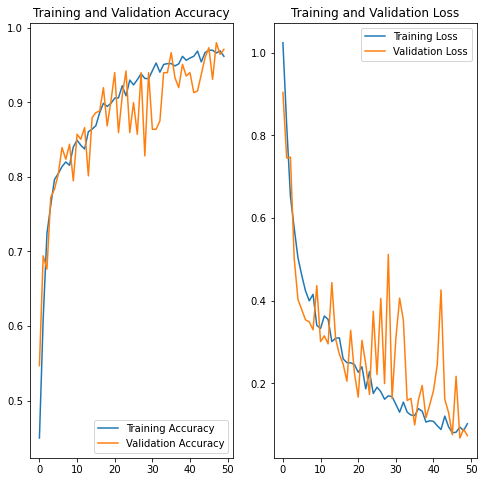

In [54]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#predict 

first image to predict
actual label: Tomato_Early_blight
predicted label: Tomato_Early_blight


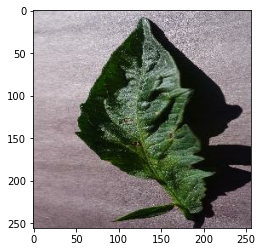

In [55]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [56]:
#model saving

In [62]:
import os
model_version=max([int(i) for i in os.listdir("Computer_vision/Models") + [0]])+1
model.save(f"Computer_vision/Models"{model_version}")

SyntaxError: invalid syntax (<ipython-input-62-b9c7a8c2ae2d>, line 3)